<a href="https://colab.research.google.com/github/tengkukevin/bert-cnn/blob/main/ROBERTA-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisialisasi

In [33]:
from transformers import BertTokenizer
import tensorflow as tf
from transformers import TFBertModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [34]:
# Baca dataset CSV
# Dataset menggunakan ISEAR
# Download dari https://www.kaggle.com/datasets/juanchristopheryoung/isear-dataset
df = pd.read_csv('/content/isear.csv')  # ganti dengan path dataset kamu

# Kolom pertama adalah label, kolom kedua adalah teks
labels = df.iloc[:, 0]
texts = df.iloc[:, 1]

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize teks menggunakan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(texts.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=128)

# Setting parameter disini
learning_rate = 1e-5
epoch = 10
batch_size = 16
dropout_rate = 0.5

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
# Ubah label ke bentuk one-hot encoding
encoded_labels = to_categorical(encoded_labels)

# Convert Tensor ke Numpy array
input_ids = np.array(inputs['input_ids'])
attention_mask = np.array(inputs['attention_mask'])

# Bagi dataset menjadi data train dan validation
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, encoded_labels, test_size=0.2, random_state=42
)

# Proses Training

In [36]:
class BERTCNNEmotionModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=3, dropout_rate=0.3):
        super(BERTCNNEmotionModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')
        self.pool1 = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training = False):
        bert_output = self.bert(inputs)[0]  # Take the last hidden state (sequence output)
        conv_output = self.conv1(bert_output)
        pooled_output = self.pool1(conv_output)
        dropout_output = self.dropout(pooled_output, training=training)
        return self.dense(dropout_output)

In [37]:
# Inisialisasi model BERT-CNN dari contoh sebelumnya
model = BERTCNNEmotionModel(num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Latih model
history = model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epoch, batch_size=batch_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.3104 - loss: 2.0213 - precision_4: 0.3111 - recall_4: 0.2809 - val_accuracy: 0.4353 - val_loss: 1.0718 - val_precision_4: 0.5152 - val_recall_4: 0.1294
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3688 - loss: 1.7632 - precision_4: 0.3714 - recall_4: 0.3257 - val_accuracy: 0.4673 - val_loss: 1.0083 - val_precision_4: 0.6402 - val_recall_4: 0.1842
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3814 - loss: 1.6385 - precision_4: 0.3880 - recall_4: 0.3354 - val_accuracy: 0.5388 - val_loss: 0.9546 - val_precision_4: 0.7032 - val_recall_4: 0.2344
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4245 - loss: 1.3982 - precision_4: 0.4360 - recall_4: 0.3726 - val_accuracy: 0.5738 - val_loss: 0.9164 - val_precision_4: 0.7127 - val_recall_4: 0.2907
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4060 - loss: 1.3950 - precision_4: 0.4155 - recall_4: 0

# Evaluasi

In [39]:
# Evaluasi pada data validasi
model.evaluate(val_inputs, val_labels)

# Prediksi label
y_pred = model.predict(val_inputs)

# Ambil label dengan probabilitas tertinggi (argmax)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(val_labels, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7254 - loss: 0.7533 - precision_4: 0.8517 - recall_4: 0.5195
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Precision: 0.7258216102155994
Recall: 0.726027397260274
F1-Score: 0.7256594532055771


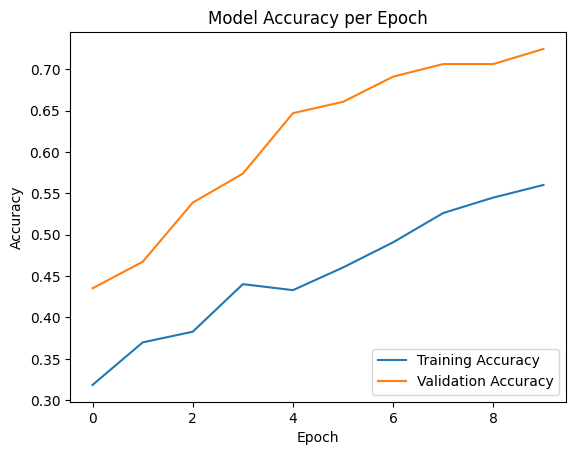

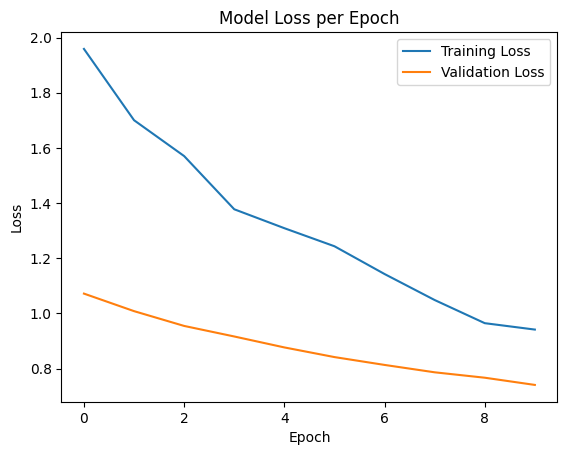

In [40]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Testing

In [32]:
# Prediksi emosi pada teks baru
new_texts = ["why this is happening to me", "I am so happy today"]
new_inputs = tokenizer(new_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)

predictions = model.predict(new_inputs['input_ids'])
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
['sadness' 'joy' 'disgust' 'sadness']
